In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import pandas as pd
import gensim
from gensim.parsing.preprocessing import remove_stopwords
import spacy
from pprint import pprint
import glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import en_core_web_sm

import pyLDAvis
import pyLDAvis.gensim 

from gensim import corpora, models
from gensim.models import CoherenceModel
from wordcloud import WordCloud

In [2]:
#allFiles = glob.glob("byPub100/*.csv")
#allFiles = glob.glob("byPub200/*.csv")
allFiles = glob.glob("byPub1000/*.csv")
#allFiles = glob.glob("byPub400/*.csv")

list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)

frame = pd.concat(list_, axis = 0, ignore_index = True)

In [3]:
frame.head()

,Unnamed: 0,id,title,publication,author,date,year,month,content
0,0,64831,11 reasons driving a supercar isn’t as cool as...,Business Insider,Matthew DeBord,2016-12-31,2016.0,12.0,"’Ah, supercars! They are the thoroughbreds of ..."
1,1,64832,16 events from 2016 that should give you hope ...,Business Insider,Chris Weller,2016-12-31,2016.0,12.0,"’This past year might have been a trying one, ..."
2,2,64837,I lived in Times Square for a year — here’s wh...,Business Insider,NaN,2016-12-31,2016.0,12.0,’NEW YORK — While most New Yorkers avoid th...
3,3,64839,Keep tabs on the latest from Business Insider ...,Business Insider,NaN,2016-12-31,2016.0,12.0,’Business Insider is known for giving you all ...
4,4,64840,At least 39 killed in attack on Istanbul night...,Business Insider,NaN,2017-01-02,2017.0,1.0,’ ’ ” ISTANBUL (AP) — An assailant belie...


In [4]:
texts = list(frame['content'])

In [5]:
no_sw_texts = [remove_stopwords(t.lower()) for t in texts ]

In [6]:
#no_sw_texts[0]

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        

clean_sents = list(sent_to_words(no_sw_texts))

In [8]:
len(clean_sents)

15000

In [9]:
#print(clean_sents[0:5])

In [10]:
bigram = gensim.models.Phrases(clean_sents, min_count=20)

In [11]:
type(bigram)

gensim.models.phrases.Phrases

In [12]:
print(bigram)

Phrases<3712837 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>


In [13]:
trigram = gensim.models.Phrases(bigram[clean_sents], min_count=10)  

In [14]:
bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)

In [15]:
clean_sents = [trigram_model[bigram_model[t]] for t in clean_sents]

In [16]:
nlp = spacy.load('en', disable=['parser', 'ner'])

nlp2 = en_core_web_sm.load()

# NOUN, ADJ, VERB, ADV
def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = []
    remove_list = []
    for index, sent in enumerate(texts):
        doc = nlp(" ".join(sent)) 
        
        output_text = [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.is_stop == False]
    
        doc2 = nlp2(" ".join(sent)) 
        
        ne_list = [token.text for token in doc2.ents if token.label_ != 'DATE']
        # three copies of named entities to give them more weight
        output_text.extend(ne_list)
        output_text.extend(ne_list)
        output_text.extend(ne_list)
        
        texts_out.append(output_text)
#        if len(output_text) == 0:
        if len(output_text) < 10:
            remove_list.append(index)
            
        
    return (texts_out, remove_list)

In [17]:
print(len(clean_sents))


15000


In [18]:
for s in clean_sents:
    print(type(s))
    break

<class 'list'>


In [19]:
%%time
clean_sents, remove_list = lemmatization(clean_sents)

CPU times: user 38min 25s, sys: 3min 52s, total: 42min 17s
Wall time: 22min 57s


In [20]:
frame['clean_sents'] = clean_sents

In [21]:
print(len(clean_sents))

15000


In [22]:
print(remove_list)

[2, 13, 30, 59, 210, 212, 251, 252, 291, 304, 335, 356, 371, 377, 379, 385, 406, 457, 461, 468, 472, 476, 483, 487, 506, 511, 518, 531, 533, 559, 568, 569, 577, 579, 599, 603, 679, 680, 728, 729, 798, 854, 862, 960, 976, 984, 1209, 1319, 1539, 1566, 1729, 1733, 1782, 1842, 1849, 1910, 4265, 4279, 4280, 4294, 4297, 4306, 4310, 4336, 4468, 4560, 5670, 5773, 5835, 7314, 7322, 7367, 7554, 7556, 7926, 8079, 8133, 8158, 8191, 8293, 8476, 8938, 9132, 9321, 9360, 9408, 9446, 9448, 9465, 9555, 9700, 9704, 10002, 10003, 10012, 10058, 10091, 10095, 10129, 10163, 10167, 10181, 10222, 10248, 10255, 10263, 10279, 10291, 10299, 10324, 10330, 10343, 10368, 10377, 10380, 10430, 10450, 10452, 10478, 10482, 10497, 10499, 10534, 10545, 10580, 10593, 10606, 10637, 10657, 10661, 10721, 10757, 10769, 10770, 10791, 10806, 10816, 10818, 10878, 10888, 10907, 10971, 10973, 10974, 10975, 10995, 10998, 12227, 12407, 12690, 12731, 12809, 12839, 12851, 12852, 12886, 12897, 12900, 12905, 12906, 12913, 12924, 12930, 1

In [23]:
print(frame.shape)

(15000, 10)


In [24]:
frame.drop(frame.index[remove_list], inplace=True)
frame = frame.reset_index(drop=True)


In [25]:
print(frame.shape)

(14829, 10)


In [26]:
clean_sents = frame['clean_sents'].tolist()

In [27]:
clean_sents[0:2]

[['thoroughbred',
  'world',
  'million',
  'attention',
  'traffic',
  'valet',
  'line',
  'people',
  'lamborghini',
  'mclaren',
  'young_age',
  'experience',
  'midlife',
  'crisis',
  'brand',
  'machine',
  'capture',
  'imagination',
  'they_re',
  'pain',
  'ground',
  'clearance',
  'isn',
  'supercar',
  'forte',
  'machine',
  'air',
  'wind',
  'aerodynamic',
  'road',
  'course',
  'roadway',
  'thousands_dollar',
  'damage',
  'car',
  'america',
  'crumbling_infrastructure',
  'foe',
  'pleasure',
  'lamborghini',
  'speed',
  'bump',
  'horsepower',
  'pony',
  'circumstance',
  'use',
  'incinerate',
  'gasoline',
  'rate',
  'tap',
  'power',
  'run',
  'gamut',
  'risk',
  'control',
  'car',
  'accident',
  'speed',
  'endure',
  'ticket',
  'supercar',
  'traffic',
  'hope',
  'potential',
  'power',
  'you_ll',
  'supercar',
  'face',
  'question',
  'supercar',
  'supercar',
  'feel_pressure',
  'man',
  'metal',
  'bang',
  'need',
  'investment',
  'ride',
  

In [28]:
id2word = gensim.corpora.Dictionary(clean_sents)

#id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
id2word.filter_extremes(no_below=15, no_above=0.9, keep_n=100000)

corpus = [id2word.doc2bow(t) for t in clean_sents]

In [29]:

# tfidf = models.TfidfModel(corpus)
# corpus = tfidf[corpus]

In [30]:
print(len(corpus))

14829


In [31]:
[(id2word[id], freq) for id, freq in corpus[0]]

[('accident', 1),
 ('air', 1),
 ('america', 1),
 ('angle', 1),
 ('approach', 1),
 ('aren', 3),
 ('art', 1),
 ('attention', 3),
 ('attitude', 1),
 ('bang', 1),
 ('bank_account', 1),
 ('beverage', 1),
 ('bird', 1),
 ('boon', 1),
 ('bottle', 1),
 ('brake', 1),
 ('brand', 1),
 ('brother', 1),
 ('brotherhood', 1),
 ('brush', 1),
 ('bump', 2),
 ('bureaucrat', 1),
 ('caffeine', 1),
 ('california', 1),
 ('capacity', 1),
 ('capture', 1),
 ('car', 6),
 ('carbon', 1),
 ('cargo', 2),
 ('case', 1),
 ('catch', 1),
 ('chance', 1),
 ('character', 1),
 ('circumstance', 1),
 ('clearance', 2),
 ('coffee', 1),
 ('comfort', 1),
 ('command', 1),
 ('condition', 1),
 ('control', 1),
 ('couple', 1),
 ('course', 1),
 ('crisis', 1),
 ('damage', 1),
 ('day', 3),
 ('dealership', 1),
 ('declaration', 1),
 ('demand', 1),
 ('didn', 1),
 ('drive', 1),
 ('driver', 1),
 ('dude', 1),
 ('east', 1),
 ('endure', 1),
 ('event', 1),
 ('exception', 1),
 ('experience', 1),
 ('face', 1),
 ('fact', 1),
 ('feel_pressure', 1),
 ('f

In [32]:
number_topics = 15

In [33]:
%%time
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=number_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=32,
                                           per_word_topics=True)

CPU times: user 4min, sys: 40.9 s, total: 4min 41s
Wall time: 5min 47s


In [34]:
pprint(lda_model.print_topics(num_topics=-1))

[(0,
  '0.035*"hours" + 0.024*"south_carolina" + 0.022*"hour" + 0.015*"refugee" + '
  '0.014*"flight" + 0.013*"airport" + 0.011*"official" + 0.011*"plane" + '
  '0.010*"country" + 0.010*"visa"'),
 (1,
  '0.073*"china" + 0.055*"company" + 0.030*"chinese" + 0.022*"india" + '
  '0.018*"apple" + 0.014*"technology" + 0.013*"product" + 0.011*"customer" + '
  '0.011*"silicon_valley" + 0.010*"app"'),
 (2,
  '0.036*"police" + 0.020*"officer" + 0.016*"man" + 0.011*"attack" + '
  '0.011*"victim" + 0.011*"gun" + 0.009*"death" + 0.009*"case" + 0.009*"crime" '
  '+ 0.009*"authority"'),
 (3,
  '0.026*"case" + 0.020*"court" + 0.018*"law" + 0.015*"state" + '
  '0.014*"decision" + 0.012*"government" + 0.012*"judge" + 0.010*"lawyer" + '
  '0.009*"office" + 0.009*"employee"'),
 (4,
  '0.028*"people" + 0.019*"american" + 0.017*"student" + 0.014*"school" + '
  '0.012*"way" + 0.011*"christian" + 0.010*"country" + 0.010*"america" + '
  '0.007*"university" + 0.007*"thing"'),
 (5,
  '0.052*"trump" + 0.032*"repu

In [35]:
top_topics = lda_model.get_document_topics(corpus[0])

In [36]:
top_topics

[(0, 0.022580037),
 (1, 0.033249784),
 (2, 0.049019344),
 (4, 0.060255237),
 (6, 0.13367286),
 (7, 0.04573737),
 (11, 0.22422686),
 (12, 0.3550238),
 (14, 0.07451561)]

In [37]:
type(corpus)

list

In [38]:
print(corpus[1000])

[(2, 3), (43, 1), (44, 1), (57, 1), (125, 1), (126, 1), (152, 2), (162, 1), (184, 1), (202, 1), (207, 1), (240, 1), (276, 1), (290, 1), (319, 1), (335, 1), (346, 3), (361, 1), (379, 4), (380, 1), (418, 2), (424, 1), (430, 1), (498, 1), (508, 1), (509, 3), (534, 1), (559, 1), (579, 2), (585, 3), (590, 1), (596, 1), (625, 1), (640, 1), (673, 1), (679, 2), (680, 1), (735, 1), (737, 1), (836, 1), (838, 1), (852, 2), (854, 2), (916, 1), (982, 2), (1021, 3), (1094, 2), (1098, 4), (1102, 1), (1106, 2), (1112, 1), (1120, 1), (1169, 1), (1178, 1), (1212, 1), (1230, 1), (1234, 12), (1299, 1), (1313, 1), (1500, 1), (1501, 1), (1525, 2), (1546, 1), (1552, 1), (1555, 1), (1762, 3), (1838, 1), (1964, 1), (2031, 1), (2038, 1), (2053, 1), (2058, 1), (2144, 9), (2161, 1), (2401, 3), (2627, 1), (2694, 1), (2802, 1), (2832, 1), (2958, 1), (3046, 1), (3137, 1), (3639, 1), (3643, 1), (3828, 1), (3906, 1), (4056, 2), (4364, 1), (4365, 2), (4381, 1), (4457, 3), (4597, 1), (4674, 2), (5043, 2), (5380, 1), (55

In [39]:
topics_list = []
for corpse in corpus:
    topics_list.append(lda_model.get_document_topics(corpse))
    

In [40]:
print(topics_list[0:5])

[[(0, 0.022579646), (1, 0.033232782), (2, 0.049036745), (4, 0.060256213), (6, 0.1336734), (7, 0.045730893), (11, 0.22423163), (12, 0.3550238), (14, 0.074515834)], [(11, 0.27197328), (12, 0.34465218), (13, 0.34856027)], [(1, 0.25748733), (6, 0.118933395), (11, 0.165259), (12, 0.07482468), (13, 0.3717839)], [(2, 0.32877266), (7, 0.15370913), (8, 0.33394906), (10, 0.10065572), (11, 0.021370165), (13, 0.0301039), (14, 0.028672827)], [(4, 0.14524287), (5, 0.101451956), (7, 0.028405586), (8, 0.6372489), (10, 0.058589812), (11, 0.010195542), (13, 0.017821597)]]


In [41]:
topic_string_list = []
for index in range(0, number_topics):
    topic_string = f'Topic_{index}'
    frame[topic_string] = pd.Series([0 for x in range(len(frame.index))], index=frame.index)
    topic_string_list.append(topic_string)

In [42]:
frame.tail()

,Unnamed: 0,id,title,publication,author,date,year,month,content,clean_sents,...,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14
14824,996,151859,Houston shooter wore military garb with Nazi e...,Guardian,NaN,2016-09-27,2016.0,9.0,A disgruntled lawyer wearing apparel with ol...,"[lawyer, apparel, emblem, weapon, round, ammun...",...,0,0,0,0,0,0,0,0,0,0
14825,997,151867,Manchester United’s Juan Mata delivers derby d...,Guardian,Paul Wilson,2016-10-26,2016.0,10.0,Manchester United’s week took a much needed tu...,"[week, turn, juan, mata, goal, cup, expense, n...",...,0,0,0,0,0,0,0,0,0,0
14826,998,151883,Why millennials’ age demographic is not the de...,Guardian,Mona Chalabi,2016-09-30,2016.0,9.0,If you have been around for a sufficient numbe...,"[number, year, experiment, compare, age, ambit...",...,0,0,0,0,0,0,0,0,0,0
14827,999,151888,Ohio abortion pill restriction had no clear sa...,Guardian,Molly Redden,2016-08-30,2016.0,8.0,A 2011 Ohio abortion restriction which support...,"[ohio, abortion, restriction, supporter, healt...",...,0,0,0,0,0,0,0,0,0,0
14828,1000,151905,Why I’m optimistic about 2017,Guardian,Paul Mason,2016-12-26,2016.0,12.0,"This Christmas break, for anybody steeped in t...","[christma, anybody, assumption, thinking, mome...",...,0,0,0,0,0,0,0,0,0,0


In [43]:
print(len(topics_list))

14829


In [44]:
print(len(corpus))

14829


In [45]:
print(len(topics_list))

14829


In [46]:
for index, topics in enumerate(topics_list):
    for topic in topics:
        topic_string = f'Topic_{topic[0]}'
        frame.loc[index, topic_string] = topic[1]


In [47]:
frame.tail()

,Unnamed: 0,id,title,publication,author,date,year,month,content,clean_sents,...,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14
14824,996,151859,Houston shooter wore military garb with Nazi e...,Guardian,NaN,2016-09-27,2016.0,9.0,A disgruntled lawyer wearing apparel with ol...,"[lawyer, apparel, emblem, weapon, round, ammun...",...,0.019113,0.039634,0.000000,0.000000,0.000000,0.026331,0.110379,0.128561,0.0,0.000000
14825,997,151867,Manchester United’s Juan Mata delivers derby d...,Guardian,Paul Wilson,2016-10-26,2016.0,10.0,Manchester United’s week took a much needed tu...,"[week, turn, juan, mata, goal, cup, expense, n...",...,0.000000,0.000000,0.639011,0.000000,0.065744,0.031299,0.046825,0.036583,0.0,0.104414
14826,998,151883,Why millennials’ age demographic is not the de...,Guardian,Mona Chalabi,2016-09-30,2016.0,9.0,If you have been around for a sufficient numbe...,"[number, year, experiment, compare, age, ambit...",...,0.387358,0.025700,0.000000,0.000000,0.049301,0.000000,0.106450,0.000000,0.0,0.000000
14827,999,151888,Ohio abortion pill restriction had no clear sa...,Guardian,Molly Redden,2016-08-30,2016.0,8.0,A 2011 Ohio abortion restriction which support...,"[ohio, abortion, restriction, supporter, healt...",...,0.000000,0.000000,0.031294,0.016590,0.375374,0.000000,0.366206,0.092204,0.0,0.000000
14828,1000,151905,Why I’m optimistic about 2017,Guardian,Paul Mason,2016-12-26,2016.0,12.0,"This Christmas break, for anybody steeped in t...","[christma, anybody, assumption, thinking, mome...",...,0.064263,0.025667,0.112843,0.251175,0.000000,0.036146,0.000000,0.031601,0.0,0.024509


In [48]:
frame['publication'].value_counts()

New York Post          1000
New York Times         1000
Vox                    1000
Reuters                1000
NPR                     999
Guardian                998
Fox News                997
Washington Post         994
Buzzfeed News           993
Atlantic                990
National Review         990
Breitbart               990
CNN                     979
Business Insider        954
Talking Points Memo     945
Name: publication, dtype: int64

In [49]:
sumframe = frame.groupby(['publication']).sum()

In [50]:
sumframe

,Unnamed: 0,id,year,month,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14
publication,,,,,,,,,,,,,,,,,,,
Atlantic,495694,77164941,1996125.0,6188.0,24.045722,26.550110,41.105114,52.305716,130.537149,108.912570,43.989012,79.741243,73.534395,40.638093,53.437018,102.850649,109.881761,60.661563,33.922688
Breitbart,493598,38009674,1996147.0,5442.0,32.739949,18.114481,73.857293,48.326938,97.705255,164.262994,38.329525,57.112830,75.733752,49.117378,68.977728,35.200473,69.858815,115.781351,33.467355
Business Insider,477578,65876389,1923561.0,5314.0,29.941009,82.883902,44.574263,46.862589,51.999280,97.464581,117.259981,63.653743,45.726049,38.290334,78.220184,75.795613,70.621308,64.929231,33.285782
Buzzfeed News,497373,105733800,2002208.0,5439.0,33.306418,55.270468,103.558532,92.336007,65.554786,65.823565,40.432979,62.284517,55.107243,38.112224,58.314825,77.782030,106.600107,81.382399,47.703340
CNN,482475,56153958,1973635.0,5403.0,44.379716,19.060445,96.695369,51.590096,60.091104,100.069778,23.846882,84.175630,82.640990,33.717218,83.077812,79.826872,114.106791,49.198908,48.963477
Fox News,497370,84732408,2007922.0,6511.0,37.174330,15.684935,118.534831,63.273833,59.782162,195.200436,23.643829,52.126958,67.572704,32.038447,85.053041,52.887043,77.631467,65.046484,41.990064
Guardian,499443,151101029,1998357.0,6193.0,28.102392,29.502041,62.401635,52.343048,77.574603,67.613073,39.653891,139.912837,78.401490,26.833856,48.485452,91.135988,139.435998,58.423717,51.209852
NPR,500006,167881495,2014316.0,5551.0,27.049900,32.824348,52.795153,53.371607,88.369490,67.461632,44.319272,90.870443,48.255245,43.957444,49.862629,133.717849,150.416423,59.170963,49.233379
National Review,496199,117279272,1996154.0,5264.0,11.789133,12.913330,24.745308,56.382015,175.515511,185.030536,46.217849,37.646083,93.968785,67.240471,59.342358,56.482584,82.590160,51.339275,22.048992


In [51]:
sumframe = sumframe.drop(columns=['Unnamed: 0', 'id', 'year', 'month'])

In [52]:
sumframe

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14
publication,,,,,,,,,,,,,,,
Atlantic,24.045722,26.550110,41.105114,52.305716,130.537149,108.912570,43.989012,79.741243,73.534395,40.638093,53.437018,102.850649,109.881761,60.661563,33.922688
Breitbart,32.739949,18.114481,73.857293,48.326938,97.705255,164.262994,38.329525,57.112830,75.733752,49.117378,68.977728,35.200473,69.858815,115.781351,33.467355
Business Insider,29.941009,82.883902,44.574263,46.862589,51.999280,97.464581,117.259981,63.653743,45.726049,38.290334,78.220184,75.795613,70.621308,64.929231,33.285782
Buzzfeed News,33.306418,55.270468,103.558532,92.336007,65.554786,65.823565,40.432979,62.284517,55.107243,38.112224,58.314825,77.782030,106.600107,81.382399,47.703340
CNN,44.379716,19.060445,96.695369,51.590096,60.091104,100.069778,23.846882,84.175630,82.640990,33.717218,83.077812,79.826872,114.106791,49.198908,48.963477
Fox News,37.174330,15.684935,118.534831,63.273833,59.782162,195.200436,23.643829,52.126958,67.572704,32.038447,85.053041,52.887043,77.631467,65.046484,41.990064
Guardian,28.102392,29.502041,62.401635,52.343048,77.574603,67.613073,39.653891,139.912837,78.401490,26.833856,48.485452,91.135988,139.435998,58.423717,51.209852
NPR,27.049900,32.824348,52.795153,53.371607,88.369490,67.461632,44.319272,90.870443,48.255245,43.957444,49.862629,133.717849,150.416423,59.170963,49.233379
National Review,11.789133,12.913330,24.745308,56.382015,175.515511,185.030536,46.217849,37.646083,93.968785,67.240471,59.342358,56.482584,82.590160,51.339275,22.048992


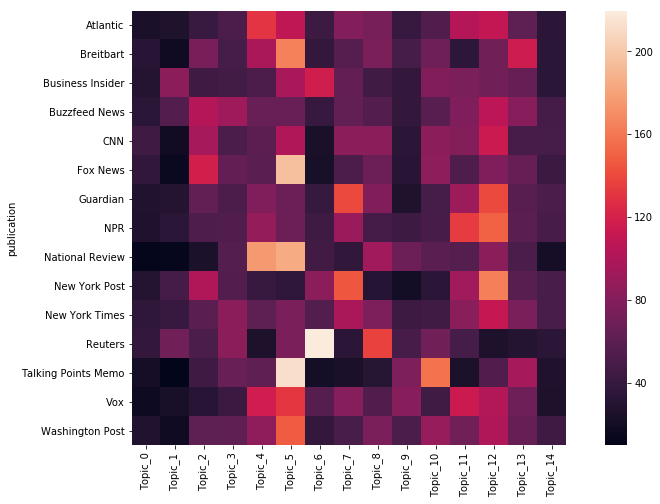

In [53]:
plt.figure(figsize=(14,8))
#sns.heatmap(sumframe, annot=True)
sns.heatmap(sumframe, square=True)

<Figure size 864x1008 with 0 Axes>

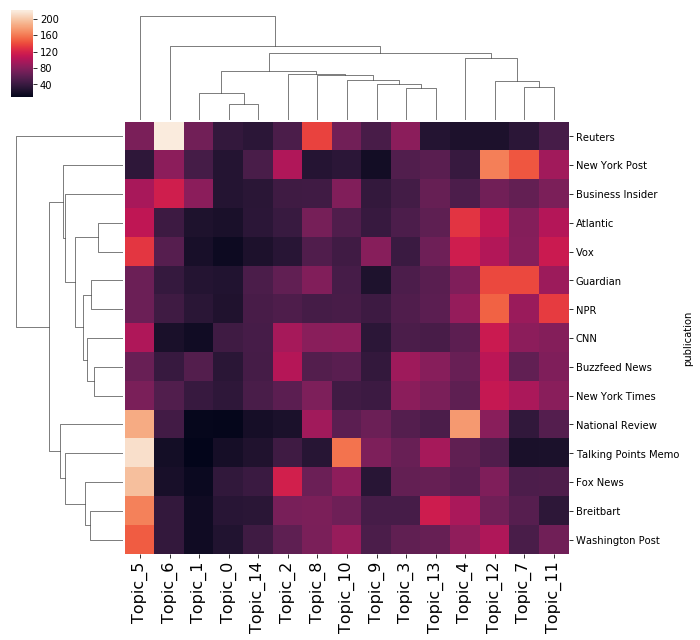

In [54]:
plt.figure(figsize=(12,14))
plt.rcParams["xtick.labelsize"] = 16
ax = sns.clustermap(sumframe)
plt.savefig('figures/clustering.png', bbox_inches='tight')
plt.show()

<Figure size 864x1008 with 0 Axes>

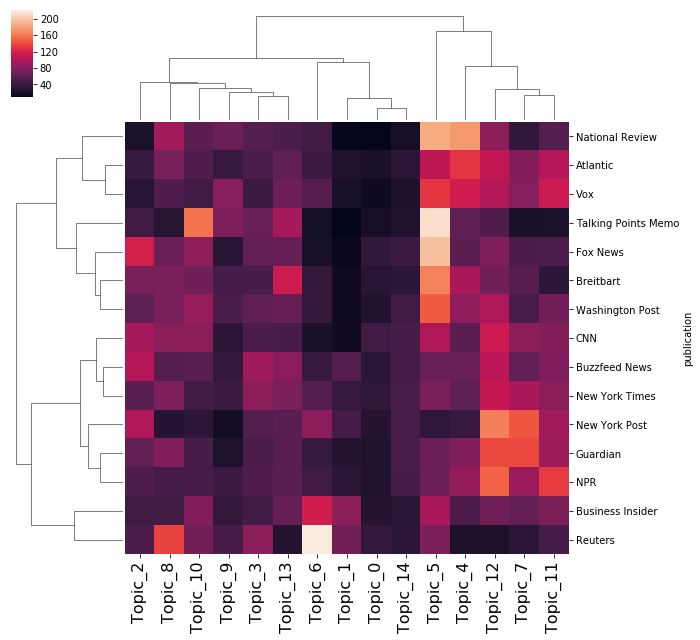

In [55]:
plt.figure(figsize=(12,14))
sns.clustermap(sumframe, method='ward')

<Figure size 864x1152 with 0 Axes>

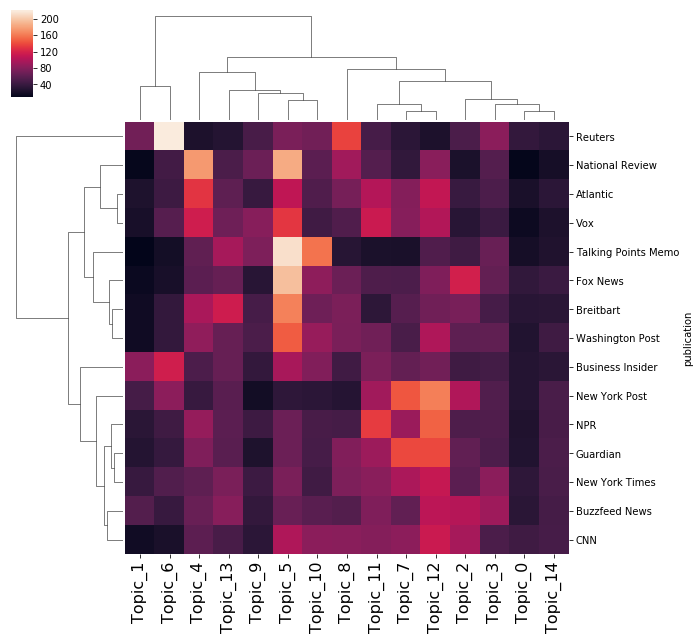

In [56]:
plt.figure(figsize=(12,16))
sns.clustermap(sumframe, metric='cosine')

In [57]:
def print_loadings(row):
    for index, col in enumerate(topic_string_list):
        print(f'{index} {row[col]}')


In [58]:
for topic_string in topic_string_list:
    sorted_frame = frame.sort_values(by=[topic_string], ascending=False)
    print(f'Topic: {topic_string}')
    print(f'Title: {sorted_frame["title"].iloc[0]}  Pub: {sorted_frame["publication"].iloc[0]}')
    print(sorted_frame["content"].iloc[0])
    print_loadings(sorted_frame.iloc[0])
    print(f'Title: {sorted_frame["title"].iloc[1]}  Pub: {sorted_frame["publication"].iloc[1]}')
    print(sorted_frame["content"].iloc[1])
    print_loadings(sorted_frame.iloc[1])
    print(f'Title: {sorted_frame["title"].iloc[2]}  Pub: {sorted_frame["publication"].iloc[2]}')
    print(sorted_frame["content"].iloc[2])
    print_loadings(sorted_frame.iloc[2])
    print(f'Title: {sorted_frame["title"].iloc[3]}  Pub: {sorted_frame["publication"].iloc[3]}')
    print(sorted_frame["content"].iloc[3])
    print_loadings(sorted_frame.iloc[3])
    print()

Topic: Topic_0
Title: Watch the US Coast Guard bust a suspected smuggling vessel in the Pacific Ocean  Pub: Business Insider
’  ’ ’   Over the last two years, the US Coast Guard has been committing   personnel and resources to known   zones, bringing   intelligence and investigative resources to bear in an  on traffickers and the   flow of drugs north to the voracious US market. ’ ’   These efforts have yielded a number of large seizures in recent   months. ’ ’   On February 12, the crew of Coast Guard Cutter Stratton, on a    in the eastern   Pacific Ocean, encountered and intercepted suspected smugglers   aboard a fast boat in international waters. ’ ’   Footage released by the US government shows Coast Guard boarding   officers stopping and boarding the suspected smuggling vessel,   apprehending the people on board and conducting a search. ’ ’ ’ ”   The February 12 incident was not the Stratton’s only encounter   with suspected smugglers while it was at sea. On  the Coast Guard vess

In [59]:
for topic_string in topic_string_list:
    sorted_frame = frame.sort_values(by=[topic_string], ascending=False)
    print(f'Topic: {topic_string}')
    print(f'Title: {sorted_frame["title"].iloc[0]}  Pub: {sorted_frame["publication"].iloc[0]}')
    print(f'Title: {sorted_frame["title"].iloc[1]}  Pub: {sorted_frame["publication"].iloc[1]}')
    print(f'Title: {sorted_frame["title"].iloc[2]}  Pub: {sorted_frame["publication"].iloc[2]}')
    print(f'Title: {sorted_frame["title"].iloc[3]}  Pub: {sorted_frame["publication"].iloc[3]}')
    print()

Topic: Topic_0
Title: Watch the US Coast Guard bust a suspected smuggling vessel in the Pacific Ocean  Pub: Business Insider
Title: The Rescuing of 6,000 Migrants in the Mediterranean  Pub: Atlantic
Title: Third Piece of Debris Confirmed to Be From Missing Malaysian Jet - The New York Times  Pub: New York Times
Title:  Officials Now Believe Missing Malaysia Airlines Plane Is Not In The Search Area  Pub: Buzzfeed News

Topic: Topic_1
Title: Apple execs made a boatload of money last year — and Tim Cook wasn’t the highest paid  Pub: Business Insider
Title: Apple iPhone Is Targeted in Beijing Patent Case - The New York Times  Pub: New York Times
Title: Google reportedly plans to ’shame’ smartphone makers to fix one of the worst problems with Android  Pub: Business Insider
Title: China shows off its guns in Hong Kong  Pub: CNN

Topic: Topic_2
Title: Suspected serial killer charged with 7 slayings in Phoenix  Pub: New York Post
Title: 1 Dead In Nevada Wal-Mart Parking Lot Shooting  Pub: NPR


In [60]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.118612 -0.008793       1        1  11.667801
12     0.026485 -0.253558       2        1  10.576859
4      0.173846 -0.077004       3        1   9.652306
11     0.045672 -0.044025       4        1   8.172633
8      0.038125  0.106667       5        1   7.481404
7      0.000882 -0.195280       6        1   6.970256
10     0.085509  0.068810       7        1   6.652071
13     0.091267 -0.140768       8        1   6.252614
3      0.013605  0.170129       9        1   6.191764
6      0.046824  0.149700      10        1   5.838068
2     -0.208991 -0.061768      11        1   5.605528
9      0.098434  0.138514      12        1   5.000471
14    -0.253083 -0.046964      13        1   3.991310
1      0.007717  0.115645      14        1   3.269130
0     -0.284906  0.078695      15        1   2.677783, topic_info=     Category          Freq             Term         Total  loglift  logprob
term                                                                        
579   Default  25567.000000            trump  25567.000000  30.0000  30.0000
379   Default   7132.000000            china   7132.000000  29.0000  29.0000
1241  Default  13090.000000       republican  13090.000000  28.0000  28.0000
184   Default   8884.000000          company   8884.000000  27.0000  27.0000
1592  Default  10630.000000  hillary_clinton  10630.000000  26.0000  26.0000
1180  Default   8580.000000        democrats   8580.000000  25.0000  25.0000
287   Default   5785.000000           police   5785.000000  24.0000  24.0000
1244  Default   8492.000000      republicans   8492.000000  23.0000  23.0000
1363  Default   9649.000000            woman   9649.000000  22.0000  22.0000
233   Default   6223.000000             city   6223.000000  21.0000  21.0000
164   Default   7732.000000           you_re   7732.000000  20.0000  20.0000
947   Default  12692.000000            state  12692.000000  19.0000  19.0000
103   Default  26862.000000           people  26862.000000  18.0000  18.0000
2230  Default   4912.000000     social_media   4912.000000  17.0000  17.0000
385   Default   7432.000000          clinton   7432.000000  16.0000  16.0000
509   Default  12501.000000        president  12501.000000  15.0000  15.0000
92    Default   7186.000000          million   7186.000000  14.0000  14.0000
29    Default   9117.000000             case   9117.000000  13.0000  13.0000
1178  Default   6516.000000         democrat   6516.000000  12.0000  12.0000
1762  Default   3833.000000            hours   3833.000000  11.0000  11.0000
543   Default   4380.000000          russian   4380.000000  10.0000  10.0000
1120  Default   7637.000000          percent   7637.000000   9.0000   9.0000
240   Default  13229.000000          country  13229.000000   8.0000   8.0000
1147  Default   4813.000000          student   4813.000000   7.0000   7.0000
89    Default   8987.000000              man   8987.000000   6.0000   6.0000
2920  Default   3874.000000      north_korea   3874.000000   5.0000   5.0000
1564  Default   5333.000000              law   5333.000000   4.0000   4.0000
347   Default  10956.000000         american  10956.000000   3.0000   3.0000
258   Default   8972.000000       government   8972.000000   2.0000   2.0000
2318  Default   3890.000000            court   3890.000000   1.0000   1.0000
...       ...           ...              ...           ...      ...      ...
1754  Topic15   1048.770996           flight   1077.080933   3.5935  -4.2993
2708  Topic15    480.799164          airline    495.057617   3.5910  -5.0792
2165  Topic15    335.423828         traveler    349.685944   3.5785  -5.4393
745   Topic15    596.758423        marijuana    634.714355   3.5585  -4.8632
101   Topic15    729.394531        passenger    782.010315   3.5505  -4.6625
4254  Topic15    466.196411             boat    501.218689   3.5477  -5.1101
1783  Topic15    457.523834         

In [61]:
def entropy(row):
    sum = 0
    for col in topic_string_list:
        if row[col] != 0:
            sum -= row[col] * np.log(row[col])
            
    return sum
        

In [62]:
frame['entropy'] = frame.apply(entropy, axis=1)

In [63]:
frame.head(45)

,Unnamed: 0,id,title,publication,author,date,year,month,content,clean_sents,...,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,entropy
0,0,64831,11 reasons driving a supercar isn’t as cool as...,Business Insider,Matthew DeBord,2016-12-31,2016.0,12.0,"’Ah, supercars! They are the thoroughbreds of ...","[thoroughbred, world, million, attention, traf...",...,0.133673,0.045731,0.000000,0.000000,0.000000,0.224232,0.355024,0.000000,0.074516,1.822319
1,1,64832,16 events from 2016 that should give you hope ...,Business Insider,Chris Weller,2016-12-31,2016.0,12.0,"’This past year might have been a trying one, ...","[past_year, news_storie, bright_spot, celebrit...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.271973,0.344652,0.348560,0.000000,1.088616
2,3,64839,Keep tabs on the latest from Business Insider ...,Business Insider,NaN,2016-12-31,2016.0,12.0,’Business Insider is known for giving you all ...,"[news, need, browser, extension, time, tab, up...",...,0.118933,0.000000,0.000000,0.000000,0.000000,0.165259,0.074825,0.371784,0.000000,1.461943
3,4,64840,At least 39 killed in attack on Istanbul night...,Business Insider,NaN,2017-01-02,2017.0,1.0,’ ’ ” ISTANBUL (AP) — An assailant belie...,"[istanbul, assailant, santa_claus, costume, is...",...,0.000000,0.153709,0.333949,0.000000,0.100656,0.021370,0.000000,0.030104,0.028673,1.540430
4,5,64855,Obama’s hesitant approach to foreign policy re...,Business Insider,NaN,2017-01-03,2017.0,1.0,’ ’ ’ Barack Obama’s impending departure fr...,"[barack_obama, departure, white_house, america...",...,0.000000,0.028406,0.637249,0.000000,0.058590,0.010196,0.000000,0.017822,0.000000,1.185421
5,6,64867,A Harvard Business School psychologist says th...,Business Insider,Richard Feloni,2017-01-03,2017.0,1.0,’ ’ ’ You may be one of those people who se...,"[people, opportunity, resolution, resolution, ...",...,0.069840,0.047824,0.032471,0.000000,0.000000,0.000000,0.402769,0.000000,0.000000,1.347481
6,7,64876,Ford CEO explains the real reason the company ...,Business Insider,Matthew DeBord,2017-01-04,2017.0,1.0,"’’ ’On Tuesday, over five years in electric a...","[tuesday, year, ford, ceo_mark, field, news, c...",...,0.699465,0.000000,0.000000,0.070108,0.000000,0.061880,0.000000,0.059526,0.047705,1.073155
7,8,64881,The legal weed market is growing as fast as br...,Business Insider,Melia Robinson,2017-01-04,2017.0,1.0,’ ’ ’ Legal weed is big business. ’ ’ The...,"[weed, business, marijuana, market, billion_re...",...,0.402374,0.060511,0.000000,0.000000,0.000000,0.121705,0.023062,0.000000,0.055391,1.766904
8,9,64893,Longtime Apple fans feel forced to buy ’pathet...,Business Insider,Kif Leswing,2017-01-05,2017.0,1.0,’’ ”Apple’s most vocal critics at the moment t...,"[apple, vocal, critic, moment, mac, user, vide...",...,0.000000,0.135678,0.000000,0.000000,0.000000,0.231638,0.000000,0.026827,0.000000,1.355265
9,10,64897,Here’s what internet is like in Cuba,Business Insider,Harrison Jacobs,2017-01-05,2017.0,1.0,"’’ ’’ ’’ ’ ’ ’Since 2014, the government has o...","[government, according_reuter, cost, hour, use...",...,0.000000,0.000000,0.065836,0.036448,0.000000,0.112055,0.000000,0.000000,0.000000,1.272890


In [64]:
frame.tail()

,Unnamed: 0,id,title,publication,author,date,year,month,content,clean_sents,...,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,entropy
14824,996,151859,Houston shooter wore military garb with Nazi e...,Guardian,NaN,2016-09-27,2016.0,9.0,A disgruntled lawyer wearing apparel with ol...,"[lawyer, apparel, emblem, weapon, round, ammun...",...,0.039634,0.000000,0.000000,0.000000,0.026331,0.110379,0.128561,0.0,0.000000,1.395518
14825,997,151867,Manchester United’s Juan Mata delivers derby d...,Guardian,Paul Wilson,2016-10-26,2016.0,10.0,Manchester United’s week took a much needed tu...,"[week, turn, juan, mata, goal, cup, expense, n...",...,0.000000,0.639011,0.000000,0.065744,0.031299,0.046825,0.036583,0.0,0.104414,1.265172
14826,998,151883,Why millennials’ age demographic is not the de...,Guardian,Mona Chalabi,2016-09-30,2016.0,9.0,If you have been around for a sufficient numbe...,"[number, year, experiment, compare, age, ambit...",...,0.025700,0.000000,0.000000,0.049301,0.000000,0.106450,0.000000,0.0,0.000000,1.211897
14827,999,151888,Ohio abortion pill restriction had no clear sa...,Guardian,Molly Redden,2016-08-30,2016.0,8.0,A 2011 Ohio abortion restriction which support...,"[ohio, abortion, restriction, supporter, healt...",...,0.000000,0.031294,0.016590,0.375374,0.000000,0.366206,0.092204,0.0,0.000000,1.353984
14828,1000,151905,Why I’m optimistic about 2017,Guardian,Paul Mason,2016-12-26,2016.0,12.0,"This Christmas break, for anybody steeped in t...","[christma, anybody, assumption, thinking, mome...",...,0.025667,0.112843,0.251175,0.000000,0.036146,0.000000,0.031601,0.0,0.024509,1.703336


In [65]:
sorted_frame = frame.sort_values(by='entropy')

In [66]:
print(f'Title: {sorted_frame["title"].iloc[0]}  entropy: {sorted_frame["entropy"].iloc[0]}')
print(sorted_frame["content"].iloc[0])
print_loadings(sorted_frame.iloc[0])
print()
print(f'Title: {sorted_frame["title"].iloc[1]}  entropy: {sorted_frame["entropy"].iloc[1]}')
print(sorted_frame["content"].iloc[1])
print_loadings(sorted_frame.iloc[1])
print()
print(f'Title: {sorted_frame["title"].iloc[2]}  entropy: {sorted_frame["entropy"].iloc[2]}')
print(sorted_frame["content"].iloc[2])
print_loadings(sorted_frame.iloc[2])

Title: DON’T FREAK OUT YET: Here’s when you can tell if Donald Trump’s poll surge is the real thing  entropy: 0.011900705662597664
”A quick note on why I’m not freaking out, even as the  on Hillary Clinton.” ”We’re in a weird moment in the campaign. Trump is the presumptive Republican nominee. Clinton, technically, is not yet the Democratic nominee. This is a disadvantage for Clinton, but one that will persist only for a few more weeks.” ”Depending on the poll, something like 30% of Bernie Sanders supporters are still saying they won’t vote for Clinton if she is nominated. Some fraction of Sanders supporters really will withhold their support from Clinton, but it likely won’t be as large as the polls show now.” ”Remember: This isn’t the first campaign where the backers of a losing candidate for the nomination have claimed they wouldn’t unify behind the nominee:” ’’ ” ’t’t’tMay 2008,   poll: 60% of Clinton backers say they’d vote ObamaMay 2016,   poll: 72% of Sanders backers say they’d 

In [67]:
sorted_frame = frame.sort_values(by='entropy', ascending=False)

In [68]:
print(f'Title: {sorted_frame["title"].iloc[0]}  entropy: {sorted_frame["entropy"].iloc[0]}')
print(sorted_frame["content"].iloc[0])
print_loadings(sorted_frame.iloc[0])
print()
print(f'Title: {sorted_frame["title"].iloc[1]}  entropy: {sorted_frame["entropy"].iloc[1]}')
print(sorted_frame["content"].iloc[1])
print_loadings(sorted_frame.iloc[1])
print()
print(f'Title: {sorted_frame["title"].iloc[2]}  entropy: {sorted_frame["entropy"].iloc[2]}')
print(sorted_frame["content"].iloc[2])
print_loadings(sorted_frame.iloc[2])

Title: U.S. Presidential Race, Ryan Lochte, Rio de Janeiro: Your Monday Evening Briefing - The New York Times  entropy: 2.526871646317486
(Want to get this briefing by email? Here’s the  .) Good evening. Here’s the latest. 1. President Obama, back from his family’s vacation on Martha’s Vineyard, prepared for the final few months of his tenure. He’ll head out on Tuesday to Louisiana, where heavy flooding killed 13 people, displaced tens of thousands more, and damaged tens of thousands of buildings, including homes, businesses and schools. _____ 2. The curtain came down on the Olympic Games, but the reckoning is still underway. The host city of Rio de Janeiro is counting gains, like a revitalized port and new subway line. The U. S. team, sparkling with talent and missing many Russian challengers, won a staggering array of gold (46) silver (37) and bronze (38) medals. One big loser: Ryan Lochte. Four companies, including Speedo USA and Ralph Lauren, severed ties over the gold medalist’s d

In [69]:
def get_loadings(row):
    loadings = []
    for index, col in enumerate(topic_string_list):
        loadings.append(row[col])
    return loadings

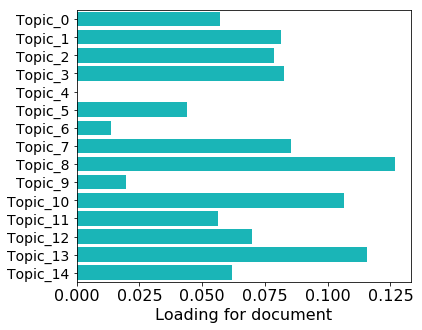

In [70]:
loads = get_loadings(sorted_frame.iloc[0])
    
plt.figure(figsize=(6,5))
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 14
    
ax = sns.barplot(y=topic_string_list, x=loads, color='darkturquoise')
ax.set(Xlabel='Loading for document')
plt.savefig('figures/high_ent_loading.png', bbox_inches='tight')
plt.show()

In [71]:
frame['entropy'].mean()

1.4950482821300402

In [72]:
new_frame = frame.copy()

In [73]:
def drop_zero_entropy(df):
    df = df[df['entropy'] > 0]
    return df

In [74]:
new_frame.sort_values(by=['entropy'], inplace=True, ascending=True)

In [75]:
new_frame = drop_zero_entropy(new_frame)

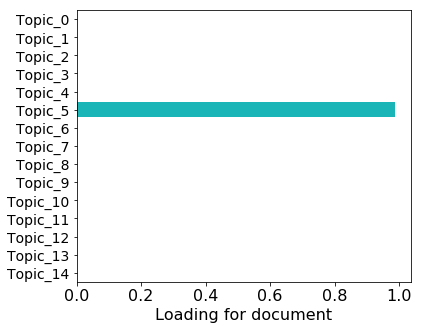

In [76]:
loads = get_loadings(new_frame.iloc[0])
    
plt.figure(figsize=(6,5))
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 14
    
ax = sns.barplot(y=topic_string_list, x=loads, color='darkturquoise')
ax.set(Xlabel='Loading for document')
plt.savefig('figures/low_ent_loading.png', bbox_inches='tight')
plt.show()

In [77]:
print(f'Title: {new_frame["title"].iloc[0]}  entropy: {new_frame["entropy"].iloc[0]}')
print(new_frame["content"].iloc[0])
print_loadings(new_frame.iloc[0])
print()
print(f'Title: {new_frame["title"].iloc[1]}  entropy: {new_frame["entropy"].iloc[1]}')
print(new_frame["content"].iloc[1])
print_loadings(new_frame.iloc[1])
print()
print(f'Title: {new_frame["title"].iloc[2]}  entropy: {new_frame["entropy"].iloc[2]}')
print(new_frame["content"].iloc[2])
print_loadings(new_frame.iloc[2])

Title: DON’T FREAK OUT YET: Here’s when you can tell if Donald Trump’s poll surge is the real thing  entropy: 0.011900705662597664
”A quick note on why I’m not freaking out, even as the  on Hillary Clinton.” ”We’re in a weird moment in the campaign. Trump is the presumptive Republican nominee. Clinton, technically, is not yet the Democratic nominee. This is a disadvantage for Clinton, but one that will persist only for a few more weeks.” ”Depending on the poll, something like 30% of Bernie Sanders supporters are still saying they won’t vote for Clinton if she is nominated. Some fraction of Sanders supporters really will withhold their support from Clinton, but it likely won’t be as large as the polls show now.” ”Remember: This isn’t the first campaign where the backers of a losing candidate for the nomination have claimed they wouldn’t unify behind the nominee:” ’’ ” ’t’t’tMay 2008,   poll: 60% of Clinton backers say they’d vote ObamaMay 2016,   poll: 72% of Sanders backers say they’d 

In [78]:
new_frame.shape

(14829, 26)

In [79]:
while new_frame['entropy'].mean() > np.log(number_topics) / 3:
    len_frame = len(new_frame.index)
    print(f'Num rows: {len_frame}  mean entropy: {new_frame["entropy"].mean()}')
    #sort by entropy, highest entropy first
    new_frame.sort_values(by=['entropy'], inplace=True, ascending=False)
    
    # drop rows with highest 5% of entropy, 
    num_to_drop = len_frame // 20
    new_frame = new_frame.iloc[num_to_drop:]
          
    new_frame = new_frame.reset_index(drop=True)
    
    #re-do lda
    clean_sents2 = new_frame['clean_sents'].tolist()
    id2word2 = gensim.corpora.Dictionary(clean_sents2)
    id2word2.filter_extremes(no_below=15, no_above=0.9, keep_n=100000)
    corpus2 = [id2word2.doc2bow(t) for t in clean_sents2]    
    
    lda_model2 = gensim.models.ldamulticore.LdaMulticore(corpus=corpus2,
                                           id2word=id2word2,
                                           num_topics=number_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=32,
                                           per_word_topics=True)    
          
    topics_list = []
    for corpse in corpus2:
        topics_list.append(lda_model2.get_document_topics(corpse))
                    
    for topic_string in topic_string_list:
          new_frame[topic_string] = 0.0
          
    for index, topics in enumerate(topics_list):
        for topic in topics:
            topic_string = f'Topic_{topic[0]}'
            new_frame.loc[index, topic_string] = topic[1]
                    
    new_frame['entropy'] = new_frame.apply(entropy, axis=1)

Num rows: 14829  mean entropy: 1.4950482821300337
Num rows: 14088  mean entropy: 1.3387181064989537
Num rows: 13384  mean entropy: 1.34676187187876
Num rows: 12715  mean entropy: 1.3133593001230741
Num rows: 12080  mean entropy: 1.3472762593835301
Num rows: 11476  mean entropy: 1.2790097622625647
Num rows: 10903  mean entropy: 1.2088152452095495
Num rows: 10358  mean entropy: 1.23775895426131
Num rows: 9841  mean entropy: 1.248887176792188
Num rows: 9349  mean entropy: 1.2636484780170096
Num rows: 8882  mean entropy: 1.2289072774601904
Num rows: 8438  mean entropy: 1.2034629156645076
Num rows: 8017  mean entropy: 1.1613247940485072
Num rows: 7617  mean entropy: 1.1285187931574747
Num rows: 7237  mean entropy: 1.0873262355193205
Num rows: 6876  mean entropy: 1.146745658358211
Num rows: 6533  mean entropy: 1.1430570689739523
Num rows: 6207  mean entropy: 1.0813747251599495
Num rows: 5897  mean entropy: 1.021341943386155
Num rows: 5603  mean entropy: 1.0024628549785923
Num rows: 5323  mea

In [80]:
print(f'Num rows: {len_frame}  mean entropy: {new_frame["entropy"].mean()}')


Num rows: 4121  mean entropy: 0.8884263187316243


In [81]:
new_frame.head()

,Unnamed: 0,id,title,publication,author,date,year,month,content,clean_sents,...,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,entropy
0,797,149509,Jane Austen at 200: still a friend and a stranger,Guardian,Lucy Worsley,2017-01-14,2017.0,1.0,“Downright nonsense” was the verdict of Mrs Au...,"[nonsense, verdict, mrs, augusta, bramston, ha...",...,0.104037,0.736469,0.0,0.120992,0.000000,0.000000,0.0,0.0,0.000000,0.835130
1,192,153939,Kale: ’the disgusting new frontier of major le...,Guardian,Amber Jamieson,2016-07-10,2016.0,7.0,The very first world record was set in Buffa...,"[world, record, buffalo, new_york, yesterday, ...",...,0.037333,0.047967,0.0,0.078697,0.000000,0.504391,0.0,0.0,0.050265,1.317755
2,446,167168,Oh! Darling: Sir Paul’s Audible Emoji For Your...,NPR,Naomi LaChance,2016-02-14,2016.0,2.0,What do Paul McCartney and Kim Kardashian have...,"[paul_mccartney, appreciation, claim_credit, r...",...,0.000000,0.235782,0.0,0.239260,0.000000,0.000000,0.0,0.0,0.379239,1.320152
3,53,123353,Can I hire someone my company previously fired?,New York Post,Greg Giangrande,2017-01-15,2017.0,1.0,Calling this “complicated” is an understatemen...,"[rehire, company, history, performance, relati...",...,0.000000,0.130338,0.0,0.468887,0.036803,0.000000,0.0,0.0,0.114889,1.330970
4,586,147245,Mary Tyler Moore obituary,Guardian,Michael Carlson,2017-01-25,2017.0,1.0,"The actor Mary Tyler Moore, who has died aged ...","[actor, sweetheart, time, role, change, turmoi...",...,0.000000,0.849496,0.0,0.017422,0.000000,0.040114,0.0,0.0,0.036106,0.615281


In [82]:
new_frame.shape

(3915, 26)

In [83]:
new_frame.tail()

,Unnamed: 0,id,title,publication,author,date,year,month,content,clean_sents,...,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,entropy
3910,671,138129,Cabela’s hunts for potential buyer in Bass Pro...,New York Post,Josh Kosman,2016-03-24,2016.0,3.0,Outdoor retailer Cabela’s is getting serious a...,"[retailer, cabela, buyer, chain, destination, ...",...,0.0,0.1596,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.452877
3911,741,190661,Wall Street rallies as traders reassess Fed ou...,Reuters,Rodrigo Campos,2016-09-12,2016.0,9.0,U. S. stocks led global shares higher on Mond...,"[stock, share, federal_reserve, policymaker, n...",...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.040700,0.02868,0.048670,0.958608
3912,542,146770,Hundreds of Syrians flee as Assad’s forces bom...,Guardian,NaN,2017-01-02,2017.0,1.0,Army and militia units supporting the Syrian p...,"[army, militia, unit, syrian_president_bashar,...",...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.448895,0.00000,0.108525,1.355042
3913,163,178943,"Syrian force a ’few weeks’ from Raqqa, U.S. Ma...",Reuters,Tom Perry,2017-03-10,2017.0,3.0,U. S. Syrian forces said on Thursday they we...,"[force, thursday, raqqa, reach, city, outskirt...",...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.638051,0.00000,0.032835,1.025309
3914,494,186199,Exclusive: Damascus vows to recapture Aleppo f...,Reuters,Tom Perry and Laila Bassam,2016-02-09,2016.0,2.0,Damascus aims to secure Syria’s border with T...,"[damascus, syria, border_turkey, city_aleppo, ...",...,0.0,0.0000,0.024417,0.0,0.0,0.0,0.535606,0.00000,0.000000,1.159467


In [84]:
pprint(lda_model2.print_topics(num_topics=-1))

[(0,
  '0.026*"study" + 0.019*"patient" + 0.017*"drug" + 0.015*"researcher" + '
  '0.015*"brain" + 0.014*"research" + 0.013*"scientist" + 0.013*"doctor" + '
  '0.013*"year" + 0.011*"moon"'),
 (1,
  '0.028*"russia" + 0.027*"russian" + 0.015*"investigation" + 0.014*"flynn" + '
  '0.013*"trump" + 0.012*"session" + 0.012*"committee" + 0.011*"meeting" + '
  '0.011*"official" + 0.010*"campaign"'),
 (2,
  '0.049*"police" + 0.034*"officer" + 0.021*"man" + 0.012*"people" + '
  '0.011*"car" + 0.011*"video" + 0.011*"authority" + 0.010*"gun" + '
  '0.009*"police_officer" + 0.009*"incident"'),
 (3,
  '0.028*"company" + 0.024*"percent" + 0.022*"year" + 0.015*"million" + '
  '0.013*"market" + 0.012*"quarter" + 0.012*"month" + 0.010*"share" + '
  '0.009*"business" + 0.009*"sale"'),
 (4,
  '0.049*"republicans" + 0.049*"republican" + 0.038*"democrats" + '
  '0.021*"democrat" + 0.016*"people" + 0.014*"obamacare" + 0.012*"plan" + '
  '0.011*"state" + 0.010*"house" + 0.009*"coverage"'),
 (5,
  '0.095*"hill

In [85]:
for topic_string in topic_string_list:
    sorted_frame = new_frame.sort_values(by=[topic_string], ascending=False)
    print(f'Topic: {topic_string}')
    print(f'Title: {sorted_frame["title"].iloc[0]}  Pub: {sorted_frame["publication"].iloc[0]}')
    print(sorted_frame["content"].iloc[0])
    print_loadings(sorted_frame.iloc[0])
          
    print(f'Title: {sorted_frame["title"].iloc[1]}  Pub: {sorted_frame["publication"].iloc[1]}')
    print(sorted_frame["content"].iloc[1])
    print_loadings(sorted_frame.iloc[1])
          
    print(f'Title: {sorted_frame["title"].iloc[2]}  Pub: {sorted_frame["publication"].iloc[2]}')
    print(sorted_frame["content"].iloc[2])
    print_loadings(sorted_frame.iloc[2])
          
    print(f'Title: {sorted_frame["title"].iloc[3]}  Pub: {sorted_frame["publication"].iloc[3]}')
    print(sorted_frame["content"].iloc[3])
    print_loadings(sorted_frame.iloc[3])
    print()

Topic: Topic_0
Title: Scientists Discover 3 ’Potentially Habitable’ Earth-Sized Planets  Pub: Talking Points Memo
Threatening to move to Canada over President Trump is out. But moving to   is in after scientists announced the discovery Monday of three   planets that could support life. The three exoplanets orbit an ultracool dwarf star formally known as 2MASS   in the constellation of Aquarius, just 40 light years away from Earth. The   star, dubbed   after the telescope used in the research, is too faint to see in the night sky with a naked eye and significantly cooler than our sun, so the planets in its orbit have temperatures similar to Earth’s, a statement from MIT said. The three planets are also the first ever discovered orbiting such a dim star. ”They could have liquid water on the surfaces, and on Earth life is critically dependent on water. We don’t know, but maybe there could be life there,” said Michaël Gillon, who led the research at the University of Liège, told the Guardi

Topic: Topic_5
Title: Bernie Sanders says he will vote for Hillary Clinton  Pub: Vox
  —   MSNBC (@MSNBC) June 24, 2016    However, Sanders was also pretty clear about why he hasn’t ended his campaign or officially endorsed Clinton just yet: because he’s hoping to negotiate with her over the party platform.    ”What my job right now is, is to fight for the strongest possible platform in the Democratic convention,” he said, adding, ”That means a platform that represents working people, that stands up to big money interests.”    This makes subtext text This shouldn’t really be a surprise  —   after all, Sanders said back in April that he’d support Clinton should she win the Democratic nomination (though he did say he wasn’t sure how ”enthusiastic” he’d be about it). And he’s long been clear that he views Ralph Nader’s third party run in 2000 as a ”mistake” that helped hand the presidency to George W. Bush. Still, as June has stretched on without a concession from Sanders, some observers 

1 0.0
2 0.03477714955806732
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0835295021533966
8 0.0
9 0.041508886963129044
10 0.0
11 0.0
12 0.0
13 0.0
14 0.8282551765441895



In [86]:
for topic_string in topic_string_list:
    sorted_frame = new_frame.sort_values(by=[topic_string], ascending=False)
    print(f'Topic: {topic_string}')
    print(f'Title: {sorted_frame["title"].iloc[0]}  Pub: {sorted_frame["publication"].iloc[0]}')
          
    print(f'Title: {sorted_frame["title"].iloc[1]}  Pub: {sorted_frame["publication"].iloc[1]}')
          
    print(f'Title: {sorted_frame["title"].iloc[2]}  Pub: {sorted_frame["publication"].iloc[2]}')
          
    print(f'Title: {sorted_frame["title"].iloc[3]}  Pub: {sorted_frame["publication"].iloc[3]}')
    print()

Topic: Topic_0
Title: Scientists Discover 3 ’Potentially Habitable’ Earth-Sized Planets  Pub: Talking Points Memo
Title: Space radiation took a toll on Apollo astronauts, study says  Pub: Fox News
Title: NASA teases ‘major’ new planet discovery  Pub: New York Post
Title: Astronaut Scott Kelly retiring after longest US space mission  Pub: New York Post

Topic: Topic_1
Title: ’Unfit to lead’: Democratic members of the House Intelligence Committee start to turn on Devin Nunes  Pub: Business Insider
Title: Russian ambassador denied meeting any Trump campaign advisers one month after private meeting with Jeff Sessions  Pub: Business Insider
Title: The Trump/Russia Story Just Got A Lot Darker  Pub: Talking Points Memo
Title: WH Invokes Leaks After Brennan Confirms Trump Camp-Russia Contacts  Pub: Talking Points Memo

Topic: Topic_2
Title: 1 Dead In Nevada Wal-Mart Parking Lot Shooting  Pub: NPR
Title: Cops fatally shoot black man one minute after arriving on scene  Pub: New York Post
Title: 

In [87]:
new_frame['publication'].value_counts()

Talking Points Memo    441
Business Insider       439
Fox News               335
New York Post          325
Reuters                309
Breitbart              262
NPR                    258
Vox                    255
CNN                    232
Buzzfeed News          216
Guardian               214
Atlantic               172
Washington Post        168
New York Times         148
National Review        141
Name: publication, dtype: int64

In [88]:
cont_length = new_frame['content'].str.len()

In [89]:
sum(cont_length) / len(cont_length)

3463.9297573435506

In [90]:
cont_length = frame['content'].str.len()

In [91]:
sum(cont_length) / len(cont_length)

4834.111807943894

In [92]:
new_frame.describe()

,Unnamed: 0,id,year,month,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,entropy
count,3915.000000,3915.000000,3679.000000,3679.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000
mean,498.417880,113128.253129,2016.283229,5.422941,0.035259,0.059806,0.108541,0.102493,0.072163,0.061332,0.025129,0.103739,0.011065,0.082432,0.076957,0.073239,0.043560,0.099035,0.030174,0.888426
std,281.745163,53991.077449,0.512188,3.304877,0.116211,0.142678,0.235184,0.240075,0.204801,0.153484,0.062991,0.213126,0.060456,0.151512,0.185434,0.200905,0.119535,0.229325,0.092987,0.339889
min,0.000000,17350.000000,2013.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002533
25%,261.000000,71094.500000,2016.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.667635
50%,489.000000,97953.000000,2016.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.910226
75%,736.000000,161496.000000,2017.000000,8.000000,0.000000,0.039349,0.042876,0.040387,0.000000,0.000000,0.020638,0.071470,0.000000,0.104809,0.022325,0.031263,0.011588,0.018461,0.000000,1.138986
max,1000.000000,217991.000000,2017.000000,12.000000,0.974071,0.969891,0.973331,0.989512,0.997463,0.965745,0.906662,0.978782,0.948147,0.960193,0.990757,0.993562,0.783546,0.994202,0.979708,1.746982


In [93]:
frame.describe()

,Unnamed: 0,id,year,month,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,entropy
count,14829.000000,14829.000000,14354.000000,14354.000000,14829.000000,14829.000000,14829.000000,14829.000000,14829.000000,14829.000000,14829.000000,14829.000000,14829.000000,14829.000000,14829.000000,14829.000000,14829.000000,14829.000000,14829.000000,14829.000000
mean,499.630319,114904.201362,2016.301797,5.557545,0.029562,0.033957,0.065231,0.061270,0.080840,0.116630,0.060131,0.074240,0.069184,0.046586,0.069231,0.076853,0.099718,0.067464,0.040092,1.495048
std,289.115307,57309.143243,0.538403,3.395307,0.070557,0.085930,0.128905,0.092239,0.115138,0.198043,0.130743,0.134358,0.133033,0.107198,0.149816,0.128126,0.132447,0.105268,0.070964,0.368973
min,0.000000,17318.000000,2007.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011901
25%,249.000000,71325.000000,2016.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.273690
50%,500.000000,107416.000000,2016.000000,5.000000,0.000000,0.000000,0.000000,0.022891,0.033488,0.000000,0.000000,0.014101,0.000000,0.000000,0.000000,0.030139,0.044861,0.024480,0.000000,1.531356
75%,750.000000,165109.000000,2017.000000,8.000000,0.025758,0.021556,0.066059,0.086520,0.119425,0.152315,0.053565,0.078849,0.073247,0.041082,0.060459,0.092443,0.154058,0.091320,0.051638,1.756985
max,1000.000000,218070.000000,2017.000000,12.000000,0.843104,0.915144,0.876371,0.752146,0.750515,0.988027,0.906652,0.868614,0.917484,0.980552,0.980548,0.946820,0.860970,0.865714,0.710791,2.526872


In [94]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model2, corpus2, id2word2)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.163979  0.124325       1        1  12.242385
13    -0.176981  0.124767       2        1  11.097752
9      0.073826  0.064262       3        1   9.881600
4     -0.165621  0.037800       4        1   9.745067
3     -0.058334 -0.003917       5        1   9.156646
11     0.097252  0.150863       6        1   8.254105
2      0.091144 -0.042310       7        1   7.829149
10    -0.140942 -0.071488       8        1   6.523961
1     -0.186727 -0.062541       9        1   5.414785
5     -0.197151  0.115486      10        1   4.828882
0      0.069199 -0.100918      11        1   4.585834
12     0.019692 -0.108474      12        1   4.066123
14     0.220359  0.159219      13        1   2.970368
6      0.119256 -0.109596      14        1   2.286216
8      0.071048 -0.277478      15        1   1.117132, topic_info=     Category         Freq                    Term        Total  loglift  \
term                                                                       
443   Default  2083.000000         hillary_clinton  2083.000000  30.0000   
1246  Default  2209.000000                 clinton  2209.000000  29.0000   
547   Default  3614.000000              republican  3614.000000  28.0000   
548   Default  2868.000000             republicans  2868.000000  27.0000   
3478  Default  1727.000000             north_korea  1727.000000  26.0000   
480   Default  3914.000000                   trump  3914.000000  25.0000   
139   Default  1427.000000                   woman  1427.000000  24.0000   
657   Default  1739.000000                  police  1739.000000  23.0000   
506   Default  2597.000000               democrats  2597.000000  22.0000   
898   Default  2841.000000                 percent  2841.000000  21.0000   
307   Default  1502.000000                  you_re  1502.000000  20.0000   
70    Default  1674.000000                     man  1674.000000  19.0000   
458   Default  1195.000000                 officer  1195.000000  18.0000   
180   Default  1210.000000                    game  1210.000000  17.0000   
1254  Default   941.000000                  sander   941.000000  16.0000   
245   Default  1153.000000                 company  1153.000000  15.0000   
90    Default  4018.000000                  people  4018.000000  14.0000   
2209  Default   682.000000                    song   682.000000  13.0000   
504   Default  1797.000000                democrat  1797.000000  12.0000   
476   Default  2589.000000                   state  2589.000000  11.0000   
1962  Default   781.000000                   comey   781.000000  10.0000   
789   Default   962.000000                    cruz   962.000000   9.0000   
350   Default   983.000000                    film   983.000000   8.0000   
471   Default   681.000000                  russia   681.000000   7.0000   
472   Default   668.000000                 russian   668.000000   6.0000   
854   Default   901.000000                  attack   901.000000   5.0000   
12    Default   983.000000                    case   983.000000   4.0000   
2156  Default   815.000000                   china   815.000000   3.0000   
477   Default  1105.000000                    team  1105.000000   2.0000   
505   Default   575.000000        democratic_party   575.000000   1.0000   
...       ...          ...                     ...          ...      ...   
3731  Topic15    48.826523                musician    49.869118   4.4733   
2299  Topic15    45.119091                     gas    46.161682   4.4716   
3711  Topic15    34.974377  criminal_investigation    36.016968   4.4650   
896   Topic15    33.849567                outbreak    34.892159   4.4641   
3460  Topic15    28.653063      black_lives_matter    29.695654   4.4587   
3424  Topic15    24.168819                defiance    25.211412   4.4522   
878   Topic15    18.363569                   fever    19.406160   4.4392   

In [95]:
lda_model2.log_perplexity(corpus2)

-6.960524926445742

In [96]:
lda_model.log_perplexity(corpus)

-9.691785425411295

In [97]:
coherence_model_ldamallet = CoherenceModel(model=lda_model2, texts=clean_sents2, dictionary=id2word2, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
coherence_ldamallet

0.5948378185610211

In [98]:
coherence_model_ldamallet = CoherenceModel(model=lda_model, texts=clean_sents, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
coherence_ldamallet

0.5041963635419913

In [99]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=number_topics, id2word=id2word)

In [100]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=clean_sents, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


[(4,
  [('team', 0.021042759770509487),
   ('time', 0.01802088952091404),
   ('game', 0.017585691168538226),
   ('year', 0.017585691168538226),
   ('minutes', 0.016292355219928407),
   ('day', 0.011033197665865739),
   ('minute', 0.010512185553866522),
   ('player', 0.009758250380032365),
   ('night', 0.007815181679988232),
   ('week', 0.007036728289118816)]),
 (10,
  [('people', 0.02424805493980093),
   ('study', 0.013419828747772417),
   ('drug', 0.010779328030599384),
   ('year', 0.010730429869170253),
   ('research', 0.010382709610118659),
   ('doctor', 0.009095058025818229),
   ('problem', 0.008644108314860694),
   ('health', 0.008057330377711131),
   ('time', 0.007307558569131134),
   ('science', 0.007122832181509975)]),
 (13,
  [('woman', 0.043833764538610355),
   ('child', 0.02569517283173671),
   ('family', 0.02413351047712281),
   ('people', 0.01867002307530942),
   ('life', 0.018348367247045663),
   ('student', 0.018339043889704684),
   ('school', 0.017770319091904994),
   (

In [101]:
model_topics = ldamallet.show_topics(formatted=False)
pprint(ldamallet.print_topics(num_words=10))

[(0,
  '0.028*"police" + 0.017*"officer" + 0.016*"man" + 0.011*"gun" + '
  '0.011*"victim" + 0.010*"people" + 0.010*"case" + 0.009*"crime" + '
  '0.008*"death" + 0.008*"incident"'),
 (1,
  '0.049*"republican" + 0.039*"republicans" + 0.036*"democrats" + '
  '0.025*"democrat" + 0.016*"plan" + 0.012*"year" + 0.011*"people" + '
  '0.011*"congress" + 0.009*"house" + 0.009*"vote"'),
 (2,
  '0.026*"state" + 0.024*"case" + 0.023*"law" + 0.018*"court" + '
  '0.015*"government" + 0.014*"mexico" + 0.013*"decision" + 0.012*"order" + '
  '0.009*"policy" + 0.009*"judge"'),
 (3,
  '0.041*"trump" + 0.030*"people" + 0.015*"thing" + 0.015*"donald_trump" + '
  '0.012*"american" + 0.011*"speech" + 0.011*"obama" + 0.011*"you_re" + '
  '0.011*"america" + 0.010*"barack_obama"'),
 (4,
  '0.021*"team" + 0.018*"time" + 0.018*"game" + 0.018*"year" + 0.016*"minutes" '
  '+ 0.011*"day" + 0.011*"minute" + 0.010*"player" + 0.008*"night" + '
  '0.007*"week"'),
 (5,
  '0.022*"social_media" + 0.015*"email" + 0.014*"inf

In [102]:
#ldamallet[corpus]

In [103]:
#new_frame = frame.copy()

In [104]:
# first_it = True
# while new_frame['entropy'].mean() > 2.1 or first_it:
#     first_it = False
#     len_frame = len(new_frame.index)
#     print(f'Num rows: {len_frame}  mean entropy: {new_frame["entropy"].mean()}')

#     new_frame.sort_values(by=['entropy'], inplace=True, ascending=False)
    
#     num_to_drop = len_frame // 20
#     new_frame = new_frame.iloc[num_to_drop:]
          
#     new_frame = new_frame.reset_index(drop=True)
    
#     clean_sents2 = new_frame['clean_sents'].tolist()
#     id2word2 = gensim.corpora.Dictionary(clean_sents2)
#     id2word2.filter_extremes(no_below=15, no_above=0.9, keep_n=100000)
#     corpus2 = [id2word2.doc2bow(t) for t in clean_sents2]    
    
#     ldamallet2 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus2, num_topics=number_topics, id2word=id2word2)      
          
#     topics_list = ldamallet2[corpus2]
                    
#     for topic_string in topic_string_list:
#           new_frame[topic_string] = 0.0
          
#     for index, topics in enumerate(topics_list):
#         for topic in topics:
#             topic_string = f'Topic_{topic[0]}'
#             new_frame.loc[index, topic_string] = topic[1]
                    
#     new_frame['entropy'] = new_frame.apply(entropy, axis=1)

In [105]:
#topics_list

In [106]:
# model_topics = ldamallet2.show_topics(formatted=False)
# pprint(ldamallet2.print_topics(num_words=10))

In [107]:
# coherence_model_ldamallet = CoherenceModel(model=ldamallet2, texts=clean_sents2, dictionary=id2word2, coherence='c_v')
# coherence_model_ldamallet.get_coherence()

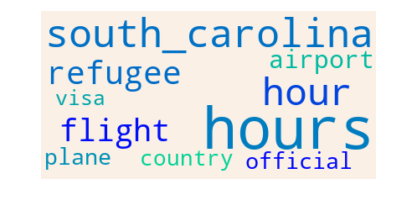

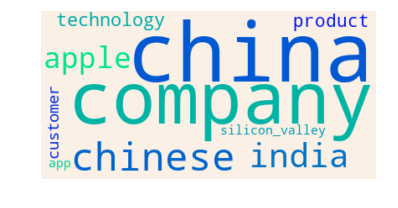

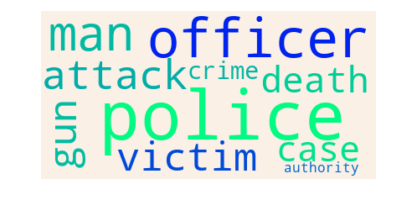

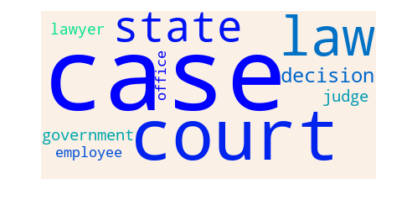

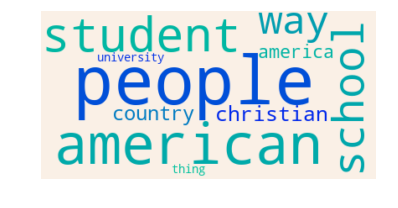

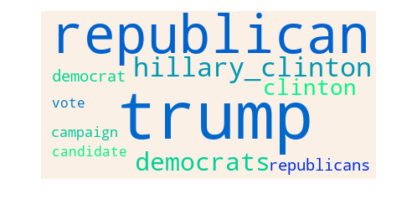

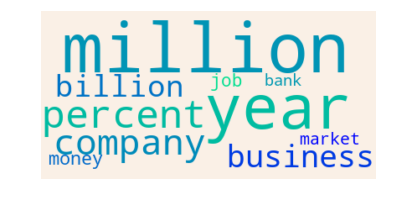

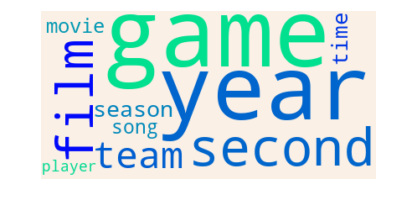

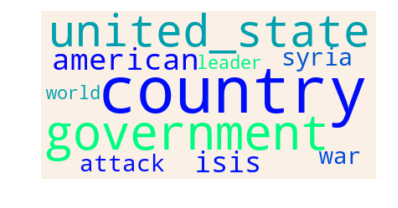

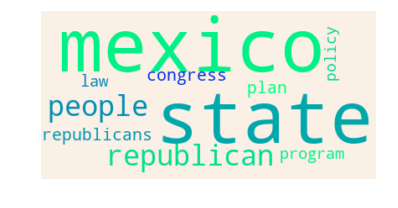

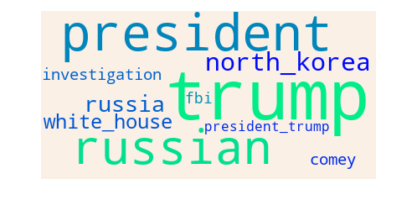

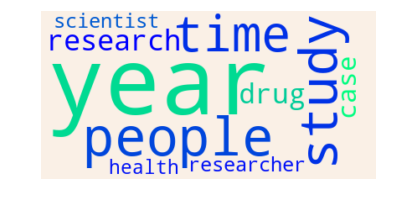

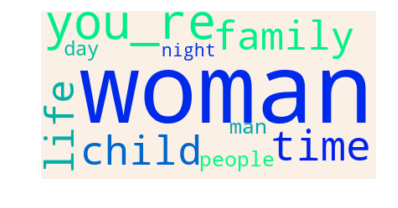

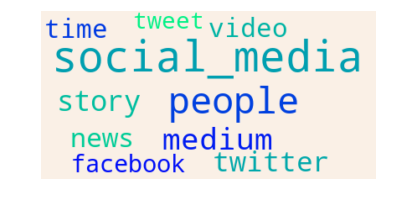

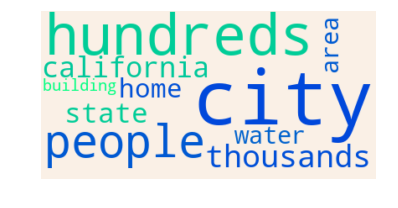

In [108]:
for t in range(lda_model.num_topics):
    d = {}
    for pair_item in lda_model.show_topic(t, 10):
        d[pair_item[0]] = pair_item[1]

    wordcloud = WordCloud(background_color='linen', colormap='winter')
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(f'figures/lda_cloud_{t}.png')
    plt.show()    

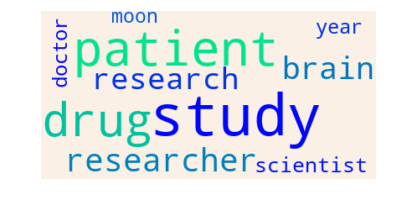

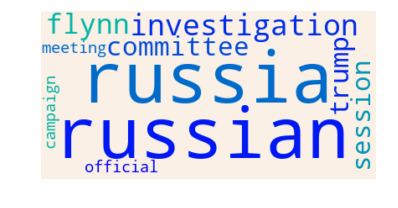

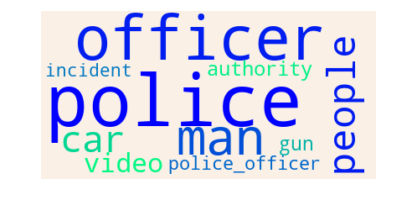

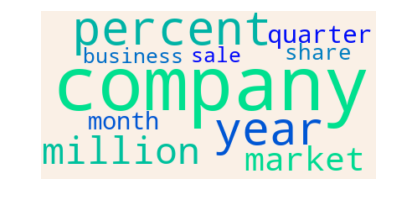

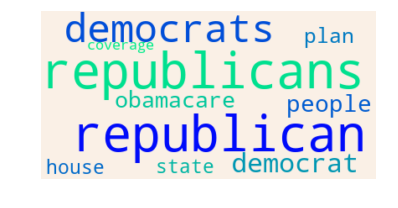

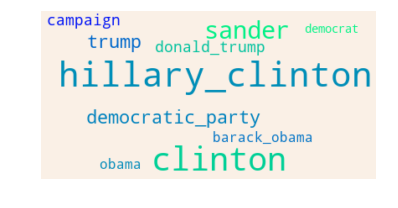

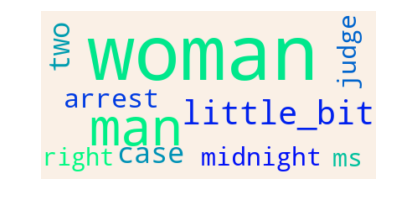

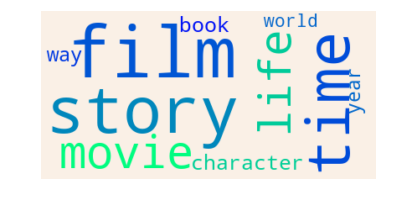

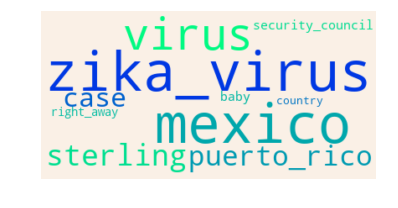

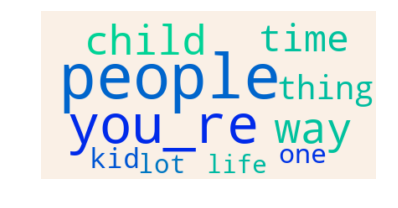

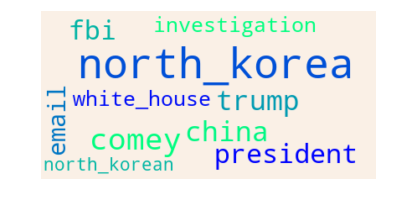

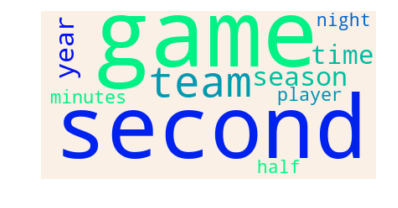

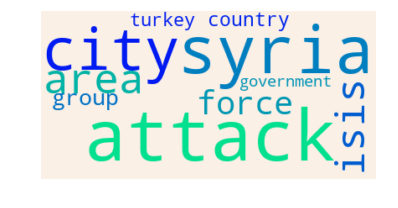

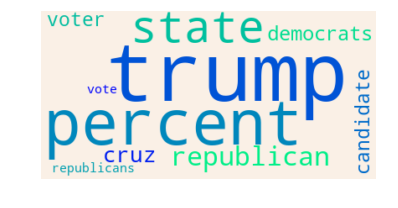

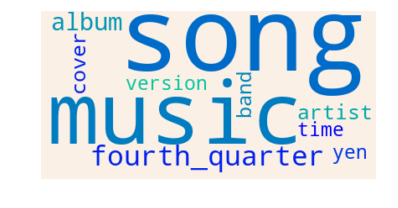

In [109]:
for t in range(lda_model2.num_topics):
    d = {}
    for pair_item in lda_model2.show_topic(t, 10):
        d[pair_item[0]] = pair_item[1]

    wordcloud = WordCloud(background_color='linen', colormap='winter')
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(f'figures/lda2_cloud_{t}.png')
    plt.show()    

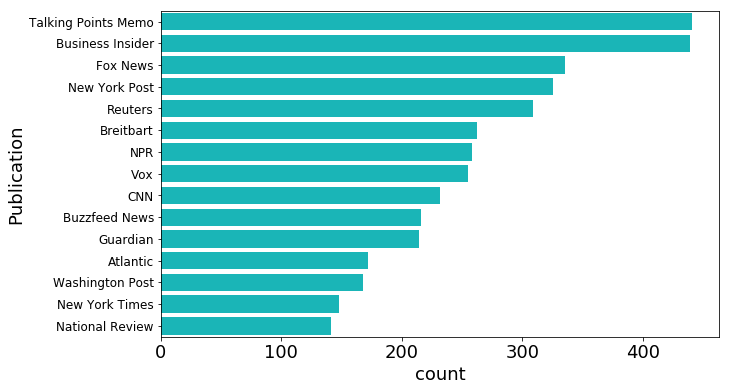

In [110]:
plt.figure(figsize=(10,6))
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 12
#plt.xticks(rotation=60, ha='right')

ax = sns.countplot(data=new_frame, y='publication',   color='darkturquoise', order=new_frame.publication.value_counts().index)
#ax.set(xlabel='')
ax.set(Ylabel='Publication')

plt.savefig('figures/pub_dist.png', bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


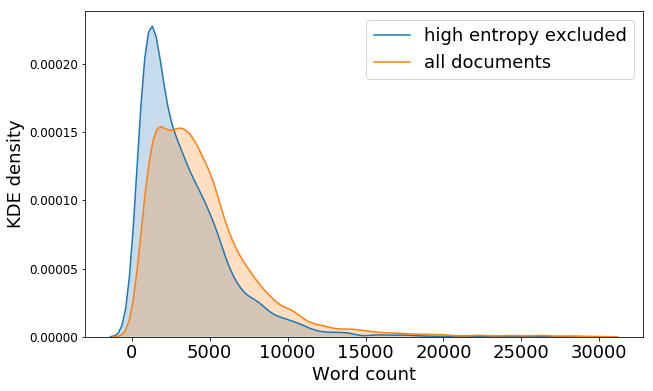

In [111]:
plt.figure(figsize=(10,6))
ax = sns.kdeplot(new_frame['content'].str.len(), shade=True, label='high entropy excluded', clip=(0.0, 30000))
sns.kdeplot(frame['content'].str.len(), shade=True, label='all documents', clip=(0.0, 30000))
ax.set(Xlabel='Word count')
ax.set(Ylabel='KDE density')
plt.legend(prop={'size': 18})
plt.savefig('figures/doc_length_dist.png', bbox_inches='tight')
plt.show()